# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In this notebook I will be investigating the Medical Cost Personal Dataset on Kagle. Specifically, I will be implementing multiple models tasked to fit this dataset in the form of a regression. These models will predict the medical cost billed by health insurers based on patient data. The performance of these models will be evaluated using root mean square error. I will be implementing a linear regressor using batch gradient descent and the normal equation, and comparing these models to a built-in stochiastic gradient descent linear regressor. 

In [1]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
file_path = "/content/insurance.csv"
insurance = pd.read_csv(file_path, delim_whitespace=False)
size = os.path.getsize(file_path)
shape = insurance.shape

print("The dataset size is: " + str(size / 1e6) + " MB" )
print("The dataset has: " + str(shape[0]) + " entries")
print("The dataset has: " + str(shape[1] - 1) + " features")
print("The features: \"sex\", \"smoker\", and \"region\" are categorical")
print("There are: " + str(insurance.isnull().values.sum()) + " null/missing values")
print("Some basic statistics you can learn about this dataset are as follows: ")
insurance.describe()

  

The dataset size is: 0.055628 MB
The dataset has: 1338 entries
The dataset has: 6 features
The features: "sex", "smoker", and "region" are categorical
There are: 0 null/missing values
Some basic statistics you can learn about this dataset are as follows: 


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING 

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

charges       1.000000
smoker        0.787251
age           0.299008
bmi           0.198341
southeast     0.073982
children      0.067998
male          0.057292
northeast     0.006349
northwest    -0.039905
southwest    -0.043210
female       -0.057292
non_smoker   -0.787251
Name: charges, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8ef50e828>,
      dtype=object)

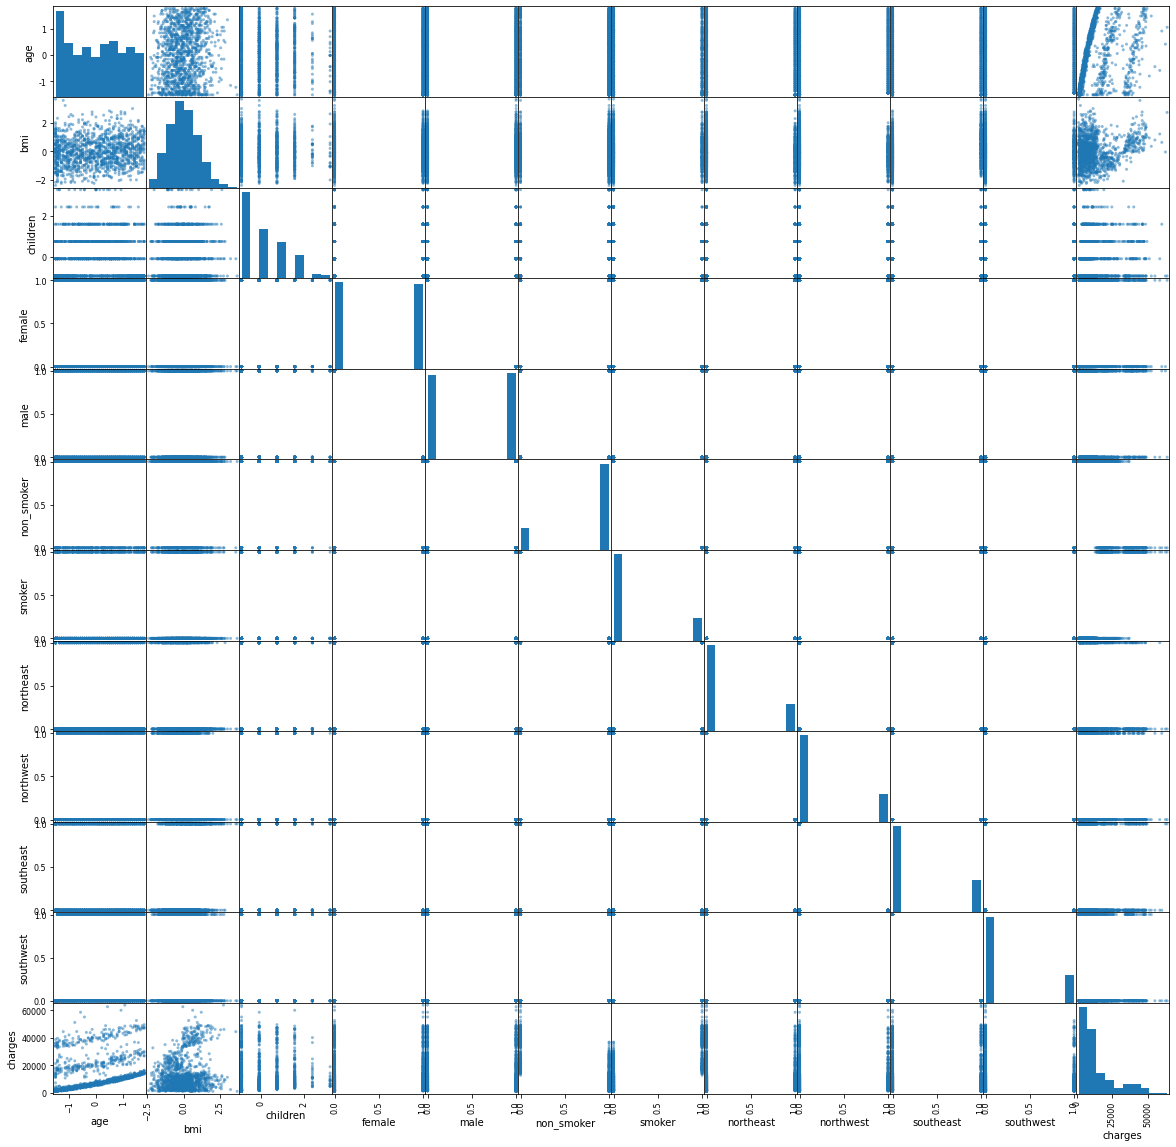

In [13]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Your code goes here for this section.
X_train = [];
y_train = [];
X_test = [];
y_test = [];

X_train, X_test = train_test_split(insurance, test_size=0.2, random_state=42)
y_train = X_train["charges"].copy()
X_train = X_train.drop("charges", axis=1)
y_test = X_test["charges"].copy()
X_test = X_test.drop("charges", axis=1)

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ('imputer', SimpleImputer(strategy="median")),
    ])

num_attribs = list(insurance.drop(["sex", "smoker", "region", "charges"], axis=1))
cat_attribs = ["sex", "smoker", "region"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_test_prepared = full_pipeline.fit_transform(X_test)
X_train_prepared = full_pipeline.fit_transform(X_train)

# This part was to find all of the category headers after transforming the data
cat_encoder = OneHotEncoder()
insurance_cat_1hot = cat_encoder.fit_transform(insurance[cat_attribs])
insurance_cat_1hot.toarray()
cat_encoder.categories_
attribs = num_attribs.copy()
attribs.extend(['female', 'male','non_smoker','smoker','northeast','northwest','southeast','southwest'])

# Run the whole dataset through the transfomer so that we can see the correlation for all features
insurance_prepared = full_pipeline.fit_transform(insurance.drop("charges", axis=1))
df = pd.DataFrame(insurance_prepared, columns = attribs)
df['charges'] = insurance['charges']

corr_matrix = df.corr()
corr_matrix.shape

print(corr_matrix['charges'].sort_values(ascending=False))
scatter_matrix(df, figsize=(20, 20))

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT 
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [3]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = []; # parameter vector;
    self.alpha = []; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    for iteration in range(iters):
      theta = theta.ravel()
      gradient = 2/X_train.shape[0] * np.dot(np.transpose(X_train), np.subtract(np.dot(X_train, theta).ravel(),y_train))
      theta = theta - alpha * gradient
      cost = np.add(np.subtract(np.dot(np.transpose(np.dot(X_train, theta)), np.dot(X_train, theta)), np.dot(2 * np.transpose(np.dot(X_train, theta)), y_train)), np.dot(np.transpose(y_train), y_train))
      self.cost.append(cost)

    self.theta = theta
    
  def fitUsingGradientDescent(self, X_train, y_train, alpha, iters):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    self.cost = []
    X_train = np.c_[np.ones((X_train.shape[0],1)), X_train]
    self.gradientDescent(X_train, y_train, np.random.randn(X_train.shape[1],1), alpha, iters)

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    self.cost = []
    X_train = np.c_[np.ones((X_train.shape[0],1)), X_train]
    self.theta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here 
    return np.dot(np.c_[np.ones((X_test.shape[0],1)), X_test], self.theta)

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    return ("Parameter vector is " + str(self.theta))
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

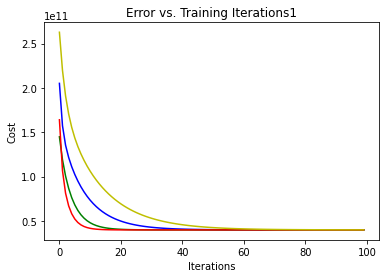

In [4]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.

iterations = []
cost1 = []
iters = 100
for i in range(iters):
  iterations.append(i)
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train, 0.1, iters)
cost1 = myGradientDescentModel.cost
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train, 0.2, iters)
cost2 = myGradientDescentModel.cost
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train, 0.3, iters)
cost3 = myGradientDescentModel.cost
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train, 0.4, iters)
cost4 = myGradientDescentModel.cost
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train, 0.5, iters)
cost5 = myGradientDescentModel.cost


plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Error vs. Training Iterations')
plt.plot(iterations, cost1, 'b')
plt.plot(iterations, cost2, 'g')
plt.plot(iterations, cost3, 'r')
plt.plot(iterations, cost4, 'y')

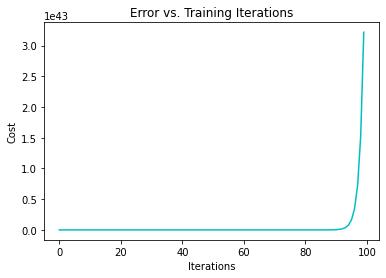

In [8]:
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Error vs. Training Iterations')
plt.plot(iterations, cost5, 'c')

After testing various learning rates, it appears that using 0.3 as the lerning rate optimizes the cost function. This is clear from the two above graphs, which plot the cost function against the number of iterations performed while using each learning rate with the gradient descent regressor. In the first graph it is clear that the red curve, which has a learning rate of 0.3, converges the quickest. In the second graph, the one curve that is plotted has a learning rate of 0.5. From this graph it is clear to see that this learning rate is too high, as the cost function diverges. Going forward I will be using a learning rate of 0.3 as it performed the best in this section.

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [5]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_prepared, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS 

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [11]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train_prepared,y_train)
y_predict = mySGDModel.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("Stochastic Gradient Descent RMSE = " + str(mySGDModel_rmse))


myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared, y_train, 0.3, 100)
y_predict = myGradientDescentModel.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predict)
myGradientDescentModel_rmse = np.sqrt(mse)
print("My Gradient Descent RMSE = " + str(myGradientDescentModel_rmse))


y_predict = myNormalEquationModel.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_predict)
myNormalEquationModel_rmse  = np.sqrt(mse)
print("My Normal Equation RMSE = " + str(myNormalEquationModel_rmse))



Stochastic Gradient Descent RMSE = 5799.7669352610465
My Gradient Descent RMSE = 5795.332646537695
My Normal Equation RMSE = 9462.247104641756


Based on the above RMSE values, which were calculated by fitting each model on the training set then running them on the test set, the SGD model and my gradient descent model yield the best performance measure for the dataset. These two produced very close RMSE values, with the normal equation RMSE being almost double the other two. From the basic statistics of the dataset calculated in part 1, we can see that the mean value of the charges category (what we are predicting) is 13270.42 with a standard deviation of 12110.01. Based on these statistics, the error from these models is okay. Although the RMSE from our best model (GD) is almost half of the mean value of the dataset, the dataset also has a very large standard deviation, which means that this RMSE is not terrible but also not great.



Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

From my preliminary work with this dataset, using a batch gradient descent model with a learning rate of 0.3 or using a stochastic gradient descent model will be able to most accurately predict patient's medical bill costs. I worked with these two models, as well as a linear regressor that used the normal equation. All three of these approaches work by trying to reduce the mean squared error produced by the model. They do so by minimizing the loss/cost function, which in turn optimizes the model. The two gradient descent models produced the lowest error after being trained and run on test data, meaning that they were the most accurate.

From working with the dataset, some of its statistics are important in understanding the problem. In particular, the mean cost of the bill is \$13270.42 and the standard deviation is \$12110.01. The standard deviation is almost as large as the mean, which shows that the dataset is very spread out. This is reinforced by the fact that range for the cost of the bill is \$62648.55. This also indicates that there may be outliers in the dataset. To improve the solution going forward, this is one area that needs to be addressed. Finding and removing outliers may make the model more accurate. In addition, all of the provided features were used in my models. Feature engineering and dropping features needs to be explored more for this dataset as this may make the model more accurate. For example, whether or not they are a smoker, their age, and the bmi of patients were the highest correlated with the cost of the bill. Exploring these features more should be a priority going forward.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!